In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import mxnet as mx
from mxnet import nd
import numpy as np

# We go over one observation at a time (speed doesn't matter here)
def transform(data, label):
    return (nd.floor(data/128)).astype(np.float32), label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

# Initialize the counters
xcount = nd.ones((784, 10))
ycount = nd.ones((10))

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:, y] += data.reshape((784))
    
# using broadcast again for division
py = ycount / ycount.sum()
px = (xcount / ycount.reshape(1, 10))

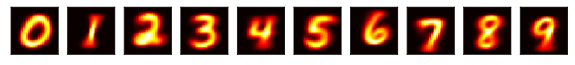

Class probabilities 
[0.09871688 0.11236461 0.09930012 0.10218297 0.09736711 0.09035161
 0.09863356 0.10441593 0.09751708 0.09915014]
<NDArray 10 @cpu(0)>


In [3]:
import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)
    
plt.show()
print('Class probabilities', py)

In [4]:
# Get the first test item
data, label = mnist_test[0]
data = data.reshape((784, 1))

# Compute the per pixel conditional probabilities
xprob = (px * data + (1 - px) * (1 - data))
# Take the product
xprob = xprob.prod(0) * py
print('Unnormalized Porbabilities', xprob)
# Normalize
xprob = xprob / xprob.sum()
print('Normalized Probabilities', xprob)

Unnormalized Porbabilities 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 10 @cpu(0)>
Normalized Probabilities 
[nan nan nan nan nan nan nan nan nan nan]
<NDArray 10 @cpu(0)>


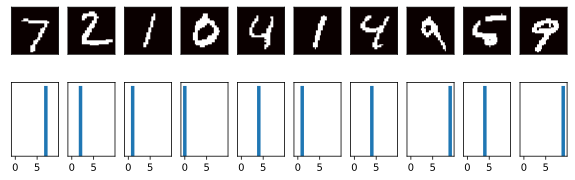

In [5]:
logpx = nd.log(px)
logpxneg = nd.log(1-px)
logpy = nd.log(py)

def bayespost(data):
    # We need to incorporate the prior probability p(y) since p(y|x) is
    # proportional to p(x|y) p(y)
    logpost = logpy.copy()
    logpost += (logpx * data + logpxneg * (1 - data)).sum(0)
    # Normalize to prevent overflow or underflow by subtracting the largest value
    logpost -= nd.max(logpost)
    # Compute the softmax using logpx
    post = nd.exp(logpost).asnumpy()
    post /= np.sum(post)
    return post

fig, figarr = plt.subplots(2, 10, figsize=(10, 3))

# Show 10 images
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784, 1))
    y = int(label)
    
    post = bayespost(x)
    
    # Bar chart and image of digit
    figarr[1, ctr].bar(range(10), post)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1
    
    if ctr == 10:
        break
        
plt.show()

In [6]:
# Initialize counter
ctr = 0
err = 0

for data, label in mnist_test:
    ctr += 1
    x = data.reshape((784, 1))
    y = int(label)
    
    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1
        
print('Naive Bayes has an error rate of', err/ctr)

Naive Bayes has an error rate of 0.1574
